In [1]:
from distributed import Executor, progress

In [3]:
e = Executor('dscheduler:8786')

In [4]:
e.restart()

<Executor: scheduler=dscheduler:8786 processes=3 cores=96>

In [5]:
import subprocess


def install_libs():
    libs = 'scikit-learn pandas matplotlib'.split()
    return subprocess.check_call('conda install -yq'.split() + libs)

install_libs()

0

In [6]:
e.run(install_libs)

{'10.112.0.5:51474': 0, '10.112.1.5:40343': 0, '10.112.2.3:40134': 0}

## The distributed.Executor API

In [7]:
def my_add(a, b):
    return a + b

f1 = e.submit(my_add, 1, 2)

In [8]:
f1

<Future: status: finished, type: int, key: my_add-df74d51e74b6ca08d254db0f26dac8cc>

In [10]:
f1.done()

True

In [9]:
f1.result()

3

In [11]:
f2 = e.submit(my_add, f1, 39)

In [12]:
f2.result()

42

In [13]:
from time import sleep

n_cores = sum(e.ncores().values())
sleep_durations = [0.1] * (n_cores * 100)

futures = e.map(sleep, sleep_durations, pure=False)
progress(futures)

## Hyperparameter search for sklearn

In [14]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()

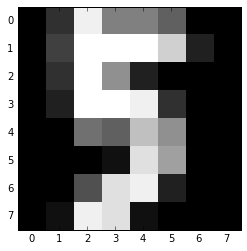

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(digits.data[35].reshape(8, 8),
           interpolation='nearest', cmap='gray');

### Sequential random parameter search

In [18]:
from sklearn.cross_validation import train_test_split


def load_cv_split(split_idx):
    data = load_digits()
    splitted = train_test_split(data.data, data.target,
                                test_size=0.20,
                                random_state=split_idx)
    return split_idx, splitted

In [19]:
from time import time
from sklearn.externals.joblib import hash


def evaluate_one(model_class, parameters, cv_split):
    split_idx, (X_train, X_val, y_train, y_val) = cv_split
    t0 = time()
    model = model_class(**parameters).fit(X_train, y_train)
    training_time = time() - t0

    train_score = model.score(X_train, y_train)
    validation_score = model.score(X_val, y_val)
    
    results = {
        'split_idx': split_idx,
        'training_time': training_time,
        'train_score': train_score,
        'val_score': validation_score,
        'parameters': parameters,
        'parameters_hash': hash(parameters),
    }
    return results

In [20]:
%%time
from sklearn.svm import SVC
from sklearn.grid_search import ParameterSampler
import numpy as np
import pandas as pd

param_grid = {
    'C': np.logspace(-10, 10, 1001),
    'gamma': np.logspace(-10, 10, 1001),
    'tol': np.logspace(-4, -1, 4),
}

param_space = ParameterSampler(param_grid, 3)

cv_splits = [load_cv_split(i) for i in range(2)]

results = [evaluate_one(SVC, params, split)
           for split in cv_splits
           for params in param_space]

CPU times: user 4.45 s, sys: 32 ms, total: 4.48 s
Wall time: 4.47 s


In [21]:
pd.DataFrame.from_dict(results).drop('parameters_hash', 1)

,parameters,split_idx,train_score,training_time,val_score
0,"{'gamma': 87096.3589956, 'tol': 0.001, 'C': 75...",0,1.000000,0.444255,0.080556
1,"{'gamma': 870963.589956, 'tol': 0.001, 'C': 3....",0,0.107168,0.398670,0.080556
2,"{'gamma': 0.00041686938347, 'tol': 0.1, 'C': 1...",0,0.107168,0.460054,0.080556
3,"{'gamma': 4.3651583224e-06, 'tol': 0.1, 'C': 0...",1,0.105776,0.473386,0.083333
4,"{'gamma': 104.712854805, 'tol': 0.1, 'C': 0.01...",1,0.105776,0.388182,0.083333
5,"{'gamma': 1659586907.44, 'tol': 0.1, 'C': 2089...",1,1.000000,0.401693,0.083333


### Scaling up with multi-threaded dask

In [22]:
from dask import delayed, compute

param_space = ParameterSampler(param_grid, 3)

cv_splits = [delayed(load_cv_split)(i) for i in range(2)]
        
delayed_evaluations = [delayed(evaluate_one)(SVC, params, split)
                       for split in cv_splits
                       for params in param_space]

In [23]:
delayed_evaluations

[Delayed('evaluate_one-4aeff320-14ad-4187-9fa2-e9a28fdb7f7e'),
 Delayed('evaluate_one-55ee2317-7777-46fc-b8cd-e66b3996d720'),
 Delayed('evaluate_one-3bcd3e7f-3e08-40d2-b25d-98706faa32d7'),
 Delayed('evaluate_one-a1e5364a-d0a2-4431-8b98-449487e2c85a'),
 Delayed('evaluate_one-d465f5d4-b486-49f4-94e7-09afd727341e'),
 Delayed('evaluate_one-6cb9c4d6-647e-4f35-b4d0-c70e35c07b00')]

In [24]:
%time results = compute(*delayed_evaluations)

CPU times: user 3.96 s, sys: 32 ms, total: 3.99 s
Wall time: 1.07 s


In [25]:
pd.DataFrame.from_dict(list(results)).drop('parameters_hash', 1)

,parameters,split_idx,train_score,training_time,val_score
0,"{'tol': 0.1, 'gamma': 4786.30092323, 'C': 16.5...",0,1.000000,0.398743,0.080556
1,"{'tol': 0.01, 'gamma': 1737800.82875, 'C': 1.1...",0,0.107168,0.398817,0.080556
2,"{'tol': 0.001, 'gamma': 79432823.4724, 'C': 1....",0,1.000000,0.457986,0.080556
3,"{'tol': 0.01, 'gamma': 0.00026302679919, 'C': ...",1,1.000000,0.066592,0.988889
4,"{'tol': 0.0001, 'gamma': 3.16227766017, 'C': 6...",1,1.000000,0.493497,0.083333
5,"{'tol': 0.01, 'gamma': 1.51356124844e-08, 'C':...",1,0.105776,0.473631,0.083333


### Scaling out with dask + distributed

In [26]:
param_space = ParameterSampler(param_grid, n_cores * 10)

cv_splits = [delayed(load_cv_split)(i) for i in range(3)]
        
delayed_evaluations = [delayed(evaluate_one)(SVC, params, split)
                       for split in cv_splits
                       for params in param_space]

In [27]:
all_results = e.compute(delayed_evaluations)

In [28]:
progress(all_results)

In [30]:
results = e.gather([f for f in all_results if f.done()])
results = pd.DataFrame.from_dict(results)
results.describe()

,split_idx,train_score,training_time,val_score
count,2880.000000,2880.000000,2880.000000,2880.000000
mean,1.000000,0.558186,0.599067,0.264886
std,0.816638,0.443614,0.227794,0.355574
min,0.000000,0.105776,0.052829,0.077778
25%,0.000000,0.105776,0.592302,0.077778
50%,1.000000,0.907794,0.662360,0.080556
75%,2.000000,1.000000,0.725853,0.083333
max,2.000000,1.000000,1.308725,0.994444


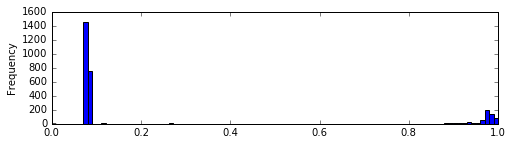

In [31]:
plt.figure(figsize=(8, 2))
bins = np.linspace(0, 1, 100)
results['val_score'].plot(kind='hist', bins=bins);

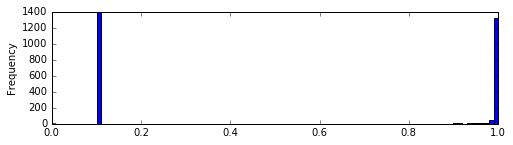

In [32]:
plt.figure(figsize=(8, 2))
results['train_score'].plot.hist(bins=bins);

In [33]:
from joblib import hash

mean_evaluations = results.groupby('parameters_hash').agg({
    'train_score': np.mean,
    'val_score': np.mean,
    'training_time': np.mean,
}).reset_index()

mean_evaluations.head(5)

,parameters_hash,train_score,training_time,val_score
0,000077cc8541f68a5d25cf01f52fcb39,1.000000,0.669638,0.077778
1,00071a06d07b99409b3225aad510807d,0.991649,0.079654,0.980556
2,0022f2e9052d1333a409cd996fcab0db,1.000000,0.695457,0.083333
3,002767880f551e49590a97b67cc5c515,0.105776,0.804121,0.083333
4,00307b82bde0629ff86b9a1b4050a0c7,0.105776,0.659076,0.083333


In [34]:
all_parameters = pd.DataFrame.from_dict(list(results['parameters']))
all_parameters['parameters_hash'] = results['parameters_hash']

evaluations = (
    mean_evaluations
    .merge(all_parameters)
    .drop(['parameters_hash'], axis=1)
)

In [35]:
top10 = evaluations.sort_values(
    by='val_score', ascending=False).head(10)
top10

,train_score,training_time,val_score,C,gamma,tol
2284,1.000000,0.257936,0.994444,2.754229e+09,1.513561e-03,0.1000
2448,1.000000,0.312985,0.994444,1.819701e+05,1.737801e-03,0.0100
883,1.000000,0.324233,0.994444,1.148154e+05,1.513561e-03,0.0100
2760,1.000000,0.234743,0.994444,3.311311e+06,1.737801e-03,0.1000
2024,1.000000,0.285540,0.994444,1.000000e+08,1.513561e-03,0.0001
1565,1.000000,0.123913,0.991667,8.317638e+08,2.884032e-07,0.0001
2216,0.988866,0.137661,0.991667,6.309573e+05,9.549926e-10,0.0010
2567,1.000000,0.097795,0.991667,1.445440e+06,5.495409e-07,0.0010
2220,0.995129,0.085136,0.991667,3.630781e+00,1.584893e-04,0.1000
2119,1.000000,0.121541,0.991667,4.786301e+09,5.248075e-06,0.0100


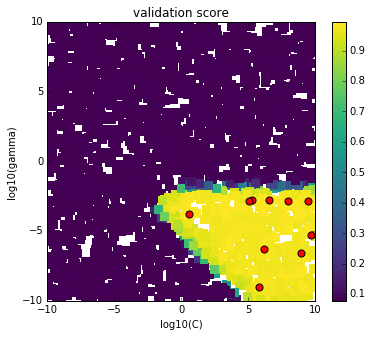

In [36]:
import matplotlib.pyplot as plt

def plot_param_map(df, target, title):
    plt.xlabel('log10(C)')
    plt.ylabel('log10(gamma)')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(np.log10(df['C']), np.log10(df['gamma']),
                c=target,
                marker='s', edgecolors='none',
                s=80, alpha=1, cmap='viridis')
    plt.colorbar()
    plt.title(title)

plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['val_score'],
               'validation score')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

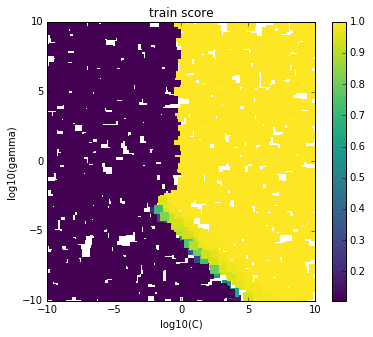

In [37]:
plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['train_score'], 'train score')

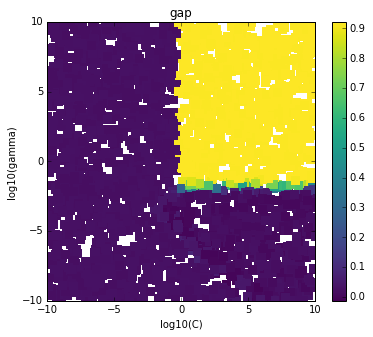

In [38]:
plt.figure(figsize=(6, 5))
gap = evaluations['train_score'] - evaluations['val_score']
plot_param_map(evaluations, gap, 'gap')

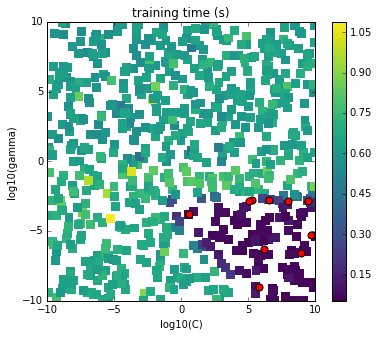

In [39]:
plt.figure(figsize=(6, 5))
high_tol = evaluations[evaluations['tol'] == 0.1]

plot_param_map(high_tol, high_tol['training_time'], 'training time (s)')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

## Scaling down

### Distributed cluster

In [40]:
import dask

%time _ = dask.compute(*delayed_evaluations[:10], get=e.get)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 1.2 s


### Single host, local python process, multiple threads

In [41]:
%time _ = dask.compute(*delayed_evaluations[:10])

CPU times: user 7.28 s, sys: 68 ms, total: 7.34 s
Wall time: 949 ms


### Single host, local python process, no parallelism

In [42]:
from dask.async import get_sync

%time _ = dask.compute(*delayed_evaluations[:10], get=get_sync)

CPU times: user 7.2 s, sys: 4 ms, total: 7.21 s
Wall time: 7.18 s


In [43]:
%prun _ = dask.compute(*delayed_evaluations[:10], get=get_sync)